### Minimum Observations

In this simplest example, let's say you have a target consisting of a planetary system around a single cool, active dwarf. For this example, we'll use AU Mic. Let's say that, given an observing strategy of once per night, we want to know how many observations we would need to achieve a threshold uncertainty on the radial velocity semi-amplitude, K, of 10%. For AU Mic, with a K of 8.5 m/s (Klein+ 2021), that means we want the minimum observations needed to reach an uncertainty of 58 cm/s. 

We'll start with the single planet case with a circular orbit and then generalize to include both AU Mic b and c. 

In [1]:
import numpy as np 
import scipy
print(np.__version__)
print(scipy.__version__)
import pandas as pd
import random
import astropy 
import tinygp
from tinygp import kernels, GaussianProcess
from numpy.linalg import inv, det, solve, cond
from tqdm import tqdm
from astropy.time import Time

import matplotlib.pyplot as plt
import matplotlib

import jax
import jax.numpy as jnp
from jax import grad, jit, vmap
#from jax import random

from gaspery import calculate_fi, strategies, utils


1.23.4
1.9.3


In [2]:
import matplotlib.pylab as pylab
pylab_params = {'legend.fontsize': 'large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}
pylab.rcParams.update(pylab_params)

path = '/Users/chris/Desktop/gaspery/'

In [17]:
def model(t, theta): 
    """
    Radial velocity model, given timestamps and planetary orbital parameters
    
    Inputs: 
    - t: time series of length N observations; np.array [day]
    - sigma: RV measurement uncertainties associated with each observation; np.array of length N [cm/s]
    - theta: planet orbital parameters; eg. [K, P, T0]; np.array
    
    theta breakdown:
    - K: RV semi-amplitude [cm/s]
    - P: planet period [days]
    - T0: mean transit time [day]

    """
    
    K, P, T0 = theta[0], theta[1], theta[2]
    arg = (2*np.pi/P)*(t-T0)
    rv = -K * np.sin(arg)
    
    return rv

def partial_mu(t, theta, wrt):
    """
    Unpack parameters and calculate all partial derivatives of the model w.r.t. those parameters
    
    Inputs: 
    - t: time series of length N observations; np.array [day]
    - theta: planet orbital parameters; eg. [K, P, T0]; np.array
    - wrt: parameter with respect to which the model's partial derivative is taken
    
    theta breakdown:
    - K: RV semi-amplitude [cm/s]
    - P: planet period [days]
    - T0: mean transit time [day]
    
    Output:
    - derivative vector of length N
    """

    # unpack parameters
    K, P, T0 = theta[0], theta[1], theta[2]
    
    # calculate partial derivative depending on 'wrt'
    normalized_t = t-T0
    arg = (2*np.pi/P) * normalized_t
    
    if wrt=='K':
        return -np.sin(arg)
    elif wrt=='P':
        return K * np.cos(arg) * arg/P
    elif wrt=='T0':
        return (2*np.pi*K/P) * np.cos(arg)
    
    print("parameter not recognized")
    
    return                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

def cov_matrix(t, params):
    """
    Build a covariance matrix, Sigma, that will be used in the calculation of the Fisher Information Matrix
    
    Inputs:
    - t: time series of length N observations; np.array [day]
    - Tau: active region lifetime [days]; free param taken from Langellier et al 2020
    - eta: smoothing parameter; free param taken from Langellier et al 2020
    - Prot: rotation period [days]; free param taken from Langellier et al 2020
    - sigma_qp_s: correlated noise amplitude; free param taken from Langellier et al 2020
    - sigma_wn_s: white noise amplitude; free param taken from Langellier et al 2020
    
    Outputs:
    - N by N matrix of covariance elements following Equations 1 & 2 of Langellier et al 2020
    
    """
    
    Tau, eta, Prot, sigma_qp_rv, sigma_wn_rv = params[0], params[1], params[2], params[3], params[4]
    
    # create N by N matrix, where N is length of observations time series
    k = np.zeros((len(t),len(t)))
    
    for i in range(len(t)):
        for j in range(len(t)):
            term1 = ((t[i]-t[j])**2)/(2*Tau**2)
            term2 = (1/(2*eta**2)) * (np.sin(np.pi * (t[i] - t[j])/Prot))**2
            arg = -term1 - term2
            k[i][j] = np.exp(arg)
    
    K = sigma_qp_rv**2 * k + sigma_wn_rv**2 * np.diag(np.ones(len(t)))
    
    return K

def calculate_fim(t, sigma, theta):
    """
    Calculate the generalized Fisher Information Matrix according to I_m,n in 
    https://en.wikipedia.org/wiki/Fisher_information#Multivariate_normal_distribution
    
    Inputs: 
    - t: time series of length N observations; np.array [day]
    - sigma: RV measurement uncertainties associated with each observation; np.array of length N [cm/s]
    - theta: planet orbital parameters; eg. [K, P, T0]; np.array
    
    theta breakdown:
    - K: RV semi-amplitude [cm/s]
    - P: planet period [days]
    - T0: mean transit time [day]
    
    Output:
    - Fisher Information Matrix: len(theta)xlen(theta) matrix; np.array
    
    """

    #print("partial mu, partial K: ", partial_mu(t, theta, 'K'))
    #print("partial mu, partial P: ", partial_mu(t, theta, 'P'))
    #print("partial mu, partial T0: ", partial_mu(t, theta, 'T0'))
    factor2 = 1/sigma**2
    factor2[factor2 == np.inf] = 0 
    
    fim = np.zeros((len(theta),len(theta)))
    
    for i in range(len(theta)):
        for j in range(len(theta)):
            #param_i = theta[i]
            #param_j = theta[j]
            #wrt_i = param_list[i]
            #wrt_j = param_list[j]
            wrt_i = ['K','P','T0'][i]
            wrt_j = ['K','P','T0'][j]
            
            factor1 = partial_mu(t, theta, wrt_i)#.reshape((1,4)) # partial derivative of the model wrt row parameter, transposed
            #print(factor1)
            ###factor2 = 1/sigma**2 # inverse of covariance matrix (or just the RV variance if held constant)
            ###factor2[factor2 == np.inf] = 0 # turn infs into zeros (shouldn't it be nans?)
            #print(factor2)
            factor3 = partial_mu(t, theta, wrt_j)#.reshape((4,1)) # partial derivative of the model wrt column parameter
            #print(factor3)
            #print("shapes: ", factor1.shape, factor2.shape, factor3.shape)
            #print(np.dot(np.dot(factor1, factor2), factor3))
            
            fim[i][j] = np.dot(np.dot(factor1, factor2), factor3)
    
    return fim

def calculate_fim_faster(t, sigma, theta):
    """
    Calculate the generalized Fisher Information Matrix by calculating partial derivatives only once
    and then plugging them into the right places. 
    
    Inputs: 
    - t: time series of length N observations; np.array [day]
    - sigma: RV measurement uncertainties associated with each observation; np.array of length N [cm/s]
    - theta: planet orbital parameters; eg. [K, P, T0]; np.array
    
    theta breakdown:
    - K: RV semi-amplitude [cm/s]
    - P: planet period [days]
    - T0: mean transit time [day]
    
    Output:
    - Fisher Information Matrix: len(theta)xlen(theta) matrix; np.array
    
    """
    
    factor2 = 1/sigma**2
    factor2[factor2 == np.inf] = 0 
    
    partial_k = partial_mu(t, theta, 'K')
    partial_p = partial_mu(t, theta, 'P')
    partial_t = partial_mu(t, theta, 'T0')
    
    fim = np.zeros((len(theta),len(theta)))
    
    for i in range(len(theta)):
        wrt_i = param_list[i]
        if wrt_i=='K':
            factor1 = partial_k
        elif wrt_i=='P':
            factor1 = partial_p
        elif wrt_i=='T0':
            factor1 = partial_t
        
        for j in range(len(theta)):
            wrt_j = param_list[j]
            if wrt_j=='K':
                factor3 = partial_k
            elif wrt_j=='P':
                factor3 = partial_p
            elif wrt_j=='T0':
                factor3 = partial_t
                            
            fim[i][j] = np.dot(np.dot(factor1, factor2), factor3)
    
    return fim

def calculate_fim_array(t, sigma, theta):
    """
    Calculate the generalized Fisher Information Matrix using np.stack instead of nested for loop
    
    Inputs: 
    - t: time series of length N observations; np.array [day]
    - sigma: RV measurement uncertainties associated with each observation; np.array of length N [cm/s]
    - theta: planet orbital parameters; eg. [K, P, T0]; np.array
    
    theta breakdown:
    - K: RV semi-amplitude [cm/s]
    - P: planet period [days]
    - T0: mean transit time [day]
    
    Output:
    - Fisher Information Matrix: len(theta)xlen(theta) matrix; np.array
    
    """
    
    factor2 = 1/sigma**2
    factor2[factor2 == np.inf] = 0 
    
    partial_k = partial_mu(t, theta, 'K')
    partial_p = partial_mu(t, theta, 'P')
    partial_t = partial_mu(t, theta, 'T0')
    
    #print(np.dot(np.dot(partial_k, factor2), partial_k))
    #print(np.array([np.dot(np.dot(partial_k, factor2), partial_k), np.dot(np.dot(partial_k, factor2), partial_p), np.dot(np.dot(partial_k, factor2), partial_t)]))
    
    fim = np.stack([np.array([np.dot(np.dot(partial_k, factor2), partial_k), np.dot(np.dot(partial_k, factor2), partial_p), np.dot(np.dot(partial_k, factor2), partial_t)]),
                  np.array([np.dot(np.dot(partial_p, factor2), partial_k), np.dot(np.dot(partial_p, factor2), partial_p), np.dot(np.dot(partial_p, factor2), partial_t)]),
                  np.array([np.dot(np.dot(partial_t, factor2), partial_k), np.dot(np.dot(partial_t, factor2), partial_p), np.dot(np.dot(partial_t, factor2), partial_t)])])
    
    return fim

def model_jax(t, K, P, T0): 
    """
    Radial velocity model, given timestamps and planetary orbital parameters, but JAXified
    (basically, np --> jnp)
    
    Inputs: 
    - t: time series of length N observations; np.array [day]
    - K: RV semi-amplitude [cm/s]
    - P: planet period [days]
    - T0: mean transit time [day]

    """
    
    #K, P, T0 = theta[0], theta[1], theta[2]
    #normalized_t = (t - T0 % P) % P # thanks, Rae! 
    #arg = (2*jnp.pi/P)*(normalized_t)
    
    arg = (2*jnp.pi/P)*(t-T0)
    rv = -K * jnp.sin(arg)
    
    return rv

def calculate_fim_jax(t, sigma, theta):
    """
    Calculate the generalized Fisher Information Matrix using JAX jacfwd to calculate partial derivatives
    
    Inputs: 
    - t: time series of length N observations; np.array [day]
    - sigma: RV measurement uncertainties associated with each observation; np.array of length N [cm/s]
    - theta: planet orbital parameters; eg. [K, P, T0]; np.array
    
    theta breakdown:
    - K: RV semi-amplitude [cm/s]
    - P: planet period [days]
    - T0: mean transit time [day]
    
    Output:
    - Fisher Information Matrix: len(theta)xlen(theta) matrix; np.array
    
    """

    factor2 = 1/sigma**2
    factor2[factor2 == np.inf] = 0 
    
    jac = jax.jacfwd(model_jax, argnums=[1,2,3])
    partials = np.array(jac(test_t, float(test_K), float(test_P), float(test_T0)))
    partial_k = partials[0]
    partial_p = partials[1]
    partial_t = partials[2]
    
    fim = np.zeros((len(theta),len(theta)))
    
    for i in range(len(theta)):
        wrt_i = param_list[i]
        if wrt_i=='K':
            factor1 = partial_k
        elif wrt_i=='P':
            factor1 = partial_p
        elif wrt_i=='T0':
            factor1 = partial_t
        
        for j in range(len(theta)):
            wrt_j = param_list[j]
            if wrt_j=='K':
                factor3 = partial_k
            elif wrt_j=='P':
                factor3 = partial_p
            elif wrt_j=='T0':
                factor3 = partial_t
                            
            fim[i][j] = np.dot(np.dot(factor1, factor2), factor3)
    
    return fim

@jax.jit
def dfms_jax_version(t, sigma, theta): # thanks, Dan! 
    """
    Calculate the generalized Fisher Information Matrix using JAX Jacobian.
    Generalizable to arbitrary parameters.
    
    Inputs: 
    - t: time series of length N observations; np.array [day]
    - sigma: RV measurement uncertainties associated with each observation; np.array of length N [cm/s]
    - theta: planet orbital parameters; eg. [K, P, T0]; np.array
    
    theta breakdown:
    - K: RV semi-amplitude [cm/s]
    - P: planet period [days]
    - T0: mean transit time [day]
    
    Output:
    - Fisher Information Matrix: len(theta)xlen(theta) matrix; np.array
    
    """
    
    def inner(params):
        return model_jax(t, params[0], params[1], params[2])
    
    factor = jnp.where(sigma > 0, 1/sigma**2, 0)    
    J = factor @ jax.jacobian(inner)(theta)
    
    return J.T @ J

In [23]:
test_theta = [K, p, T0]

def make_t(n_obs, cadence, start):
    """
    Gemerate observation times given a number of observations and an average cadence (every X nights)
    
    Input: 
    - n_obs: number of observations to try
    - cadence: amount of time between observations [days]
    - start: start time [BJD]
    
    Output:
    - observation times: ndarray
    
    """
    
    ### make a t using n_obs and cadence
    # initial obs time of 2300 is a placeholder that's set as somewhat close to the arbitrary test_T0 of 2360
    end = start + n_obs * cadence 
    t = np.linspace(start, end, n_obs, endpoint=False)
    #print(start, end, n_obs, t)
    
    # add jitter ~ N(0, 1 hr) to timestamps
    t += np.random.normal(0, 1./24)

    return t

def make_t_without_jitter(n_obs, cadence, start):
    """
    Gemerate observation times given a number of observations and an average cadence (every X nights)
    
    Input: 
    - n_obs: number of observations to try
    - cadence: amount of time between observations [days]
    - start: start time [BJD]
    
    Output:
    - observation times: ndarray
    
    """
    
    ### make a t using n_obs and cadence
    # initial obs time of 2300 is a placeholder that's set as somewhat close to the arbitrary test_T0 of 2360
    end = start + n_obs * cadence 
    t = np.linspace(2300, end, n_obs, endpoint=False)
    
    return t

def calculate(t, theta, sigma_val=None):
    """
    Allows user to try different n_obs and cadences and visualize how that affects the expected RV semi-amplitude uncertainty, sigma_K
    
    Input: 
    - start: start time from which I build out n_obs * cadence
    - n_obs: number of observations to try
    - cadence: amount of time between observations [days]
    - theta: planet orbital parameters; eg. [K, P, T0]; np.array
    - sigma_val: RV measurement uncertainties associated with each observation; float64 [cm/s]
    
    theta breakdown:
    - K: RV semi-amplitude [cm/s]
    - P: planet period [days]
    - T0: mean transit time [day]
    
    Output:
    - sigma_ks: array of sigma_k's calculated by np.linalg.inv [cm/s]
    - sigma_ks_stable: array of sigma_k's calculated by 1/np.sqrt(FIM[0][0])
    
    """
    
    ### make covariance matrix in the scalar, white noise case
    if sigma_val != None:
        sigma_val += 1e-6 # perturb sigma_val to guard against numerical instabilities
        sigma = np.diag(np.ones(len(t))) * sigma_val**2 # covariance matrix of scalar sigma_RV's
        sigma = np.linalg.solve(sigma, np.identity(len(sigma))) # invert to make factor2 for FIM
        
        fim = calculate_fim(t, sigma, theta)
        #print("FIM: ", fim)
        #print("det: ", det(fim))
        inv_fim = inv(fim)
        #print("inv: ", inv_fim)
        sigma_k = np.sqrt(inv_fim)[0][0]
        #print("sigma_K, using inv: ", sigma_k)
        #sigma_ks.append(sigma_k)
        sigma_k_stable = np.sqrt(1/fim[0][0])
        #print("sigma_K, not using inv: ", sigma_k_stable)

        # np.linalg.solve is more stable than np.linalg.inv, apparently
        inv_fim_solve = solve(fim, np.diag(np.ones(len(theta)))) 
        sigma_k_solve = np.sqrt(inv_fim_solve)[0][0]
        
        return sigma_k, sigma_k_stable, sigma_k_solve, fim
    
    ### make covariance matrix in the correlated noise case
    else:
        sigma = cov_matrix(t, params)
        sigma += 1e-6 
        sigma = inv(sigma) # I want the inverse of the covariance matrix for FIM
        
        fim = calculate_fim(t, sigma, theta)
        inv_fim = inv(fim)
        sigma_k = np.sqrt(inv_fim)[0][0]
        sigma_k_stable = np.sqrt(1/fim[0][0])
        inv_fim_solve = solve(fim, np.diag(np.ones(len(theta)))) 
        sigma_k_solve = np.sqrt(inv_fim_solve)[0][0]
        
        return sigma_k, sigma_k_stable, sigma_k_solve, fim

@jax.jit
def dfms_jax_version(t, sigma, theta): # thanks, Dan! 
    def inner(model_params):
        return model_jax(t, model_params[0], model_params[1], model_params[2])
    
    sigma += 1e-6 # add jitter
    factor = jnp.linalg.solve(sigma, jnp.identity(len(sigma))) # take inverse of covariance matrix
    #factor = jnp.linalg.inv(sigma)
    #factor = jnp.where(sigma > 0, sigma_inv, 0)  
    
    J = jax.jacobian(inner)(theta)
    
    return J.T @ factor @ J

@jax.jit
def jax_fim(t, sigma, theta, stellar_params): 
    """
    Calculate the generalized Fisher Information Matrix using JAX Jacobian.
    Generalizable to arbitrary parameters.
    Now, with second term for correlated noise. 
    
    Inputs: 
    - t: time series of length N observations; np.array [day]
    - sigma: RV measurement uncertainties associated with each observation; np.array of length N [cm/s]
    - theta: planet orbital parameters; eg. [K, P, T0]; np.array
    - stellar_params: correlated stellar noise parameters, a la Langellier et al 2021; np.array
    theta breakdown:
    - K: RV semi-amplitude [cm/s]
    - P: planet period [days]
    - T0: mean transit time [day]
    stellar_params breakdown: 
    - Tau: active region lifetime [days]
    - eta: smoothing parameter
    - Prot: rotation period [days]
    - sigma_qp_s: correlated noise amplitude
    - sigma_wn_s: white noise amplitude
    
    Output:
    - Fisher Information Matrix: len(theta)xlen(theta) matrix; np.array
    
    """
    
    def inner(params):
        return model_jax(t, params[0], params[1], params[2])
    
    def inner_sigma(t, params):
        return cov_matrix_jax(t, params)
    
    sigma += 1e-6 # add jitter
    factor = jnp.linalg.solve(sigma, jnp.identity(len(sigma))) # take inverse of covariance matrix
    #factor = jnp.linalg.inv(sigma)
    #factor = jnp.where(sigma > 0, sigma_inv, 0)  
    
    J = jax.jacobian(inner)(theta)
    first_term = J.T @ factor @ J
    
    S = jax.jacobian(inner_sigma)(t, stellar_params)
    print("factor: ", factor, factor.shape) # 30 x 30
    print("S: ", S, S.shape) # 30 x 30 x 30
          
    trace_of = factor @ S @ factor @ S
    print("trace of: ", trace_of, trace_of.shape)
    
    second_term = 0.5 * jnp.trace(trace_of)
    print(first_term, first_term.shape)
    print(second_term, second_term.shape)
    
    return first_term + second_term

def strategy_jax(start, n_obs, cadence, theta, sigma_val=None):
    """
    Allows user to try different n_obs and cadences and visualize how that affects the expected RV semi-amplitude uncertainty, sigma_K
    
    Input: 
    - start: start time from which I build out n_obs * cadence
    - n_obs: number of observations to try
    - cadence: amount of time between observations [days]
    - theta: planet orbital parameters; eg. [K, P, T0]; np.array
    - sigma_val: RV measurement uncertainties associated with each observation; float64 [cm/s]
    
    theta breakdown:
    - K: RV semi-amplitude [cm/s]
    - P: planet period [days]
    - T0: mean transit time [day]
    
    Output:
    - sigma_ks: array of sigma_k's calculated by np.linalg.inv [cm/s]
    - sigma_ks_stable: array of sigma_k's calculated by 1/np.sqrt(FIM[0][0])
    
    """
    
    ### make a t using n_obs and cadence
    # initial obs time of 2300 is a placeholder that's set as somewhat close to the arbitrary test_T0 of 2360
    t = make_t(n_obs, cadence, start)
    #print("time steps: ", t)
    
    ### make covariance matrix in the scalar, white noise case
    if sigma_val != None:
        sigma_val += 1e-6 # perturb sigma_val to guard against numerical instabilities
        sigma = np.diag(np.ones(len(t))) * sigma_val**2 # covariance matrix of scalar sigma_RV's
        sigma = np.linalg.solve(sigma, np.identity(len(sigma))) # invert to make factor2 for FIM
        
        args = t, sigma, jnp.array(theta, dtype=float)
        fim = dfms_jax_version(*args).block_until_ready()
        
        inv_fim = inv(fim)
        sigma_k = np.sqrt(inv_fim)[0][0]
        
        return fim[0][0], sigma_k
    
    ### make covariance matrix in the correlated noise case
    else:
        sigma = cov_matrix(t, params)
        sigma += 1e-6 
        sigma = inv(sigma) # I want the inverse of the covariance matrix for FIM
        
        args = t, sigma, jnp.array(theta, dtype=float)
        fim = dfms_jax_version(*args).block_until_ready()
        
        inv_fim = inv(fim)
        sigma_k = np.sqrt(inv_fim)[0][0]
        
        return fim[0][0], sigma_k

#print(strategy(start=start, n_obs=100, cadence=1, theta=test_theta, sigma_val=30)) # default to 2300

#### White noise case

We begin by declaring our target planet's orbital parameters. Our covariance matrix in the white noise regime is simply a diagonal matrix of the photon noise. In their modeling of AU Mic b, Klein+ 2021 estimated that noise to be 5 m/s. 

In [24]:
### target parameters
p = 8.46 # orbital period, days
K = 8.5 # m/s
T0 = 2458651.993 # central transit time, in BJD, on 19 June 2019

### white/photon noise
sigma_wn_rv = 5. # [m/s]

### choose start time as date of this writing
start = '2023-03-01T10:00:00'
start = Time(start, format='isot', scale='utc').jd

In [124]:
### Cloutier+ 2018 Eqn 7 formulation
sigmas = []
for s in np.arange(len(strat[4:]))+4:
    strat_sub = strat[:s]
    
    B = 0
    for t in strat_sub:
        nu = (2*np.pi/p) * (t - T0)
        B += (np.sin(nu))**2
    B = B/sigma_wn_rv**2
    
    sigmas.append(np.sqrt(1/B))

In [219]:
random = np.random.default_rng(seed=43)

### Cloutier+ 2018 Eqn 7 formulation, uniform sampling
sigmas_uniform = []
strat_subs = []
for s in np.arange(len(strat[4:]))+4:
    sigmas_uniform_i = []
    strat_subs_i = []
    for i in range(800):
        strat_sub = random.uniform(strat[0], strat[s], len(strat[:s]))

        B = 0
        for t in strat_sub:
            nu = (2*np.pi/p) * (t - T0)
            B += (np.sin(nu))**2
        B = B/sigma_wn_rv**2
        sigma_uniform_i = np.sqrt(1/B)
        sigmas_uniform_i.append(sigma_uniform_i)
        strat_subs_i.append(strat_sub)
        
    sigmas_uniform.append(np.mean(sigmas_uniform_i))
    strat_subs.append(strat_subs_i)

We must also choose an observing cadence. The base case here is an observation once per day, for a cadence (time between observations) of 1 day.

In [184]:
cadence = 1 # observing cadence of once per day

Okay! The only thing we've left unconstrained is the number of observations. We can vary them, building an increasingly longer time series of observations, each time recalculating the covariance matrix, Fisher Information, and uncertainty on the RV semi-amplitude.

In [185]:
sigma_ks = []
sigma_ks_stable = []
sigma_ks_solve = []
for n_obs in tqdm(range(60)[4:]):
    
    # instantiate Star object in order to feed covariance matrix with white/correlated noise
    star = calculate_fi.Star(sigma_wn_rv = sigma_wn_rv)
    
    # populate list of parameters to feed into cov_matrix_jax()
    params = star.param_list()
    
    # instantiate Planets object in order to feed Fisher Info calculation machinery
    planet = calculate_fi.Planets(K = K, p = p, T0 = T0)
    
    # populate list of parameters to feed into clam_jax_fim()
    theta = planet.theta_list()
    
    # instantiate Strategy object in order to build time series of observations
    strategy = strategies.Strategy(n_obs = n_obs, start = start, offs=[], dropout=0.)
    
    # build strategy aka time series of observations
    strat = strategy.gappy(cadence)
        
    #sigma = calculate_fi.cov_matrix_jax(strat, params) # non-object-oriented
    #sigma = star.cov_matrix(strat) # object-oriented but w/manual QP GP kernel
    sigma = star.cov_matrix_general(strat) # object-oriented with custom kernels
    #sigma += 1e-6 

    # populate arguments for Fisher Info calculator
    args = np.array(strat), sigma, jnp.array(theta, dtype=float)
    
    # calculate FI
    fim = calculate_fi.clam_jax_fim(*args).block_until_ready()
    
    # invert FI matrix
    inv_fim = inv(fim)
    
    #sigma_k, sigma_k_stable, sigma_k_solve, _ = calculate(strat, theta, sigma_val=5.)
    
    # top left element of matrix corresponds with RV semi-amplitude, K
    sigma_k = np.sqrt(inv_fim)[0][0]
    #sigma_k_stable = np.sqrt(1/fim[0][0])
    #sigma_k_solve = 
    
    sigma_ks.append(sigma_k)
    #sigma_ks_stable.append(sigma_k_stable)
    #sigma_ks_solve.append(sigma_k_solve)

  0%|                                                                                                                    | 0/56 [00:00<?, ?it/s]/var/folders/fm/fpkllzw93kq7c5y3zl98167m0000gn/T/ipykernel_2954/114760778.py:41: RuntimeWarning: invalid value encountered in sqrt
  sigma_k = np.sqrt(inv_fim)[0][0]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 249.42it/s]


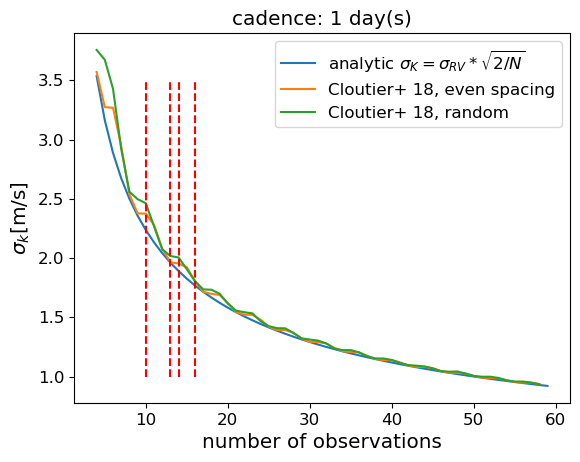

In [220]:
#plt.plot(np.arange(len(sigma_ks))+4, np.array(sigma_ks), label='calculated $\sigma_K$, white noise')
#plt.plot(np.arange(len(sigma_ks_stable))+5, np.array(sigma_ks_stable), label='calculated $\sigma_{K, stable}$, white noise')
#plt.plot(np.arange(len(sigma_ks_solve))+5, np.array(sigma_ks_solve), label='calculated $\sigma_{K, solve}$, white noise')

plt.plot(np.arange(len(sigma_ks))+4, sigma_wn_rv * np.sqrt(2/(np.arange(len(sigma_ks))+4)), label='analytic $\sigma_K = \sigma_{RV}*\sqrt{2/N}$')

plt.plot(np.arange(len(strat[4:]))+4, sigmas, label='Cloutier+ 18, even spacing')

plt.plot(np.arange(len(strat[4:]))+4, sigmas_uniform, label='Cloutier+ 18, random')

plt.vlines(10, 1, 3.5, linestyle='--', color='red')
plt.vlines(13, 1, 3.5, linestyle='--', color='red')
plt.vlines(14, 1, 3.5, linestyle='--', color='red')
plt.vlines(16, 1, 3.5, linestyle='--', color='red')

plt.xlabel('number of observations')
plt.ylabel(r"$\sigma_k$[m/s]")
plt.title(f"cadence: {cadence} day(s)")
plt.legend()
plt.show()

Huh. Looks like the wiggles are artifacts of the 1:1 correspondence between the planet's orbital period and the observing cadence. This is obviated when observations are drawn uniformly, as done in Cloutier+ 2018, but when drawn in an evenly spaced manner, this is a problem. 

Let's plot RV curves (can't really phase-fold because there's not enough data) for a strategy at the top of a wiggle (10 days) and in line with the analytical form (13 days). 

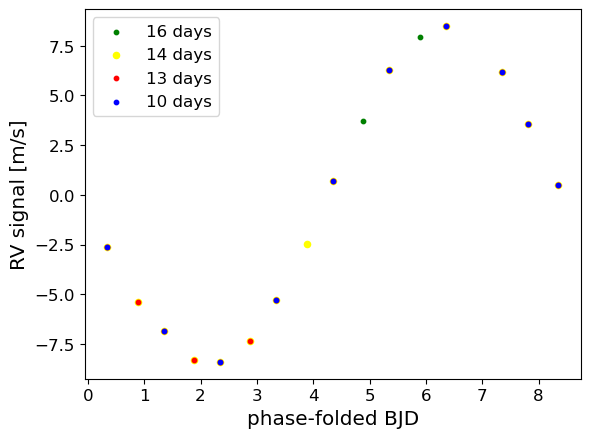

In [155]:
t_phase_folded_10 = strat[:10] % p # phase fold support
t_phase_folded_13 = strat[:13] % p # phase fold support
t_phase_folded_14 = strat[:14] % p # phase fold support
t_phase_folded_16 = strat[:16] % p # phase fold support

y10 = calculate_fi.model_jax(t_phase_folded_10, theta)
y14 = calculate_fi.model_jax(t_phase_folded_14, theta)
y13 = calculate_fi.model_jax(t_phase_folded_13, theta)
y16 = calculate_fi.model_jax(t_phase_folded_16, theta)

#plt.scatter(strat[:10], y10)
#plt.scatter(strat[:13], y13)
plt.scatter((strat[:16]-T0) % p, y16, label='16 days', c='green', s=10)
plt.scatter((strat[:14]-T0) % p, y14, label='14 days', c='yellow', s=20)
plt.scatter((strat[:13]-T0) % p, y13, label='13 days', c='red', s=10)
plt.scatter((strat[:10]-T0) % p, y10, label='10 days', c='blue', s=10)
plt.xlabel('phase-folded BJD')
plt.ylabel('RV signal [m/s]')

plt.legend()
plt.show()

When we phase fold as above, subsequent points in an evenly spaced strategy add less information when they sample far away from the minimum and maximum. 

Then we do the same below, but randomly sampling for the same number of days. We want to know why the wiggles still happen for these. 

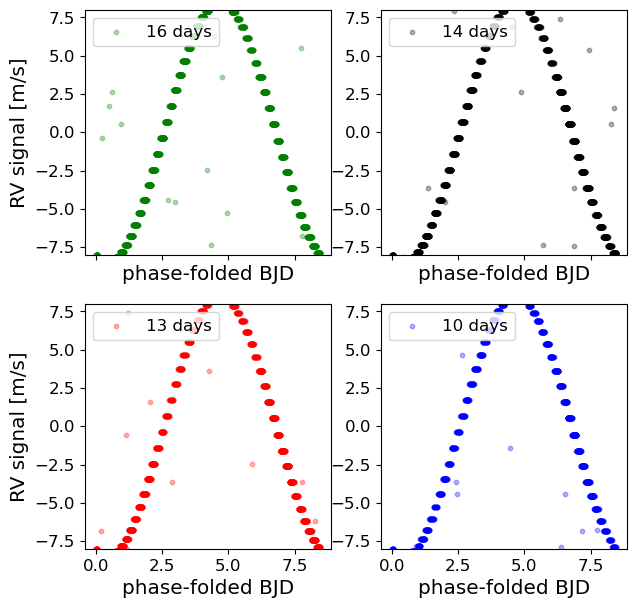

In [218]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(7, 7), sharex=True)

t_phase_folded_10 = strat_subs[6][0] % p # phase fold support
t_phase_folded_13 = strat_subs[9][0] % p # phase fold support
t_phase_folded_14 = strat_subs[10][0] % p # phase fold support
t_phase_folded_16 = strat_subs[12][0] % p # phase fold support
    
ax1.scatter(t_phase_folded_16, y16, label='16 days', c='green', s=10, alpha=0.3)
ax2.scatter(t_phase_folded_14, y14, label='14 days', c='k', s=10, alpha=0.3)
ax3.scatter(t_phase_folded_13, y13, label='13 days', c='red', s=10, alpha=0.3)
ax4.scatter(t_phase_folded_10, y10, label='10 days', c='blue', s=10, alpha=0.3)

for i in np.arange(199)+1:
    t_phase_folded_10 = strat_subs[6][i] % p # phase fold support
    t_phase_folded_13 = strat_subs[9][i] % p # phase fold support
    t_phase_folded_14 = strat_subs[10][i] % p # phase fold support
    t_phase_folded_16 = strat_subs[12][i] % p # phase fold support

    y10 = calculate_fi.model_jax(t_phase_folded_10, theta)
    y14 = calculate_fi.model_jax(t_phase_folded_14, theta)
    y13 = calculate_fi.model_jax(t_phase_folded_13, theta)
    y16 = calculate_fi.model_jax(t_phase_folded_16, theta)

    ax1.scatter(t_phase_folded_16, y16, c='green', s=10, alpha=0.3)
    ax2.scatter(t_phase_folded_14, y14, c='k', s=10, alpha=0.3)
    ax3.scatter(t_phase_folded_13, y13, c='red', s=10, alpha=0.3)
    ax4.scatter(t_phase_folded_10, y10, c='blue', s=10, alpha=0.3)

ax1.legend(loc='upper left')
ax2.legend(loc='upper left')
ax3.legend(loc='upper left')
ax4.legend(loc='upper left')

ax1.set_ylim([-8, 8])
ax2.set_ylim([-8, 8])
ax3.set_ylim([-8, 8])
ax4.set_ylim([-8, 8])

ax1.set_xlabel('phase-folded BJD')
ax2.set_xlabel('phase-folded BJD')
ax3.set_xlabel('phase-folded BJD')
ax4.set_xlabel('phase-folded BJD')

ax1.set_ylabel('RV signal [m/s]')
ax3.set_ylabel('RV signal [m/s]')

plt.show()

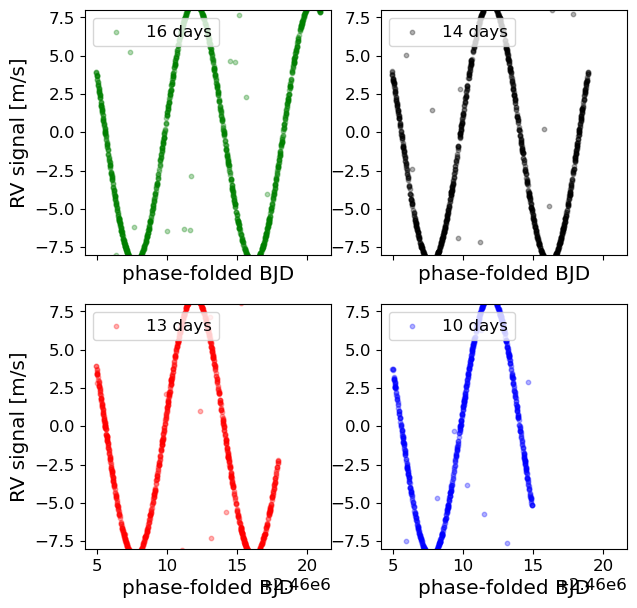

In [222]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(7, 7), sharex=True)

t_phase_folded_10 = strat_subs[6][0] 
t_phase_folded_13 = strat_subs[9][0] 
t_phase_folded_14 = strat_subs[10][0] 
t_phase_folded_16 = strat_subs[12][0] 
    
ax1.scatter(t_phase_folded_16, y16, label='16 days', c='green', s=10, alpha=0.3)
ax2.scatter(t_phase_folded_14, y14, label='14 days', c='k', s=10, alpha=0.3)
ax3.scatter(t_phase_folded_13, y13, label='13 days', c='red', s=10, alpha=0.3)
ax4.scatter(t_phase_folded_10, y10, label='10 days', c='blue', s=10, alpha=0.3)

for i in np.arange(99)+1:
    t_phase_folded_10 = strat_subs[6][i] 
    t_phase_folded_13 = strat_subs[9][i] 
    t_phase_folded_14 = strat_subs[10][i] 
    t_phase_folded_16 = strat_subs[12][i] 

    y10 = calculate_fi.model_jax(t_phase_folded_10, theta)
    y14 = calculate_fi.model_jax(t_phase_folded_14, theta)
    y13 = calculate_fi.model_jax(t_phase_folded_13, theta)
    y16 = calculate_fi.model_jax(t_phase_folded_16, theta)

    ax1.scatter(t_phase_folded_16, y16, c='green', s=10, alpha=0.3)
    ax2.scatter(t_phase_folded_14, y14, c='k', s=10, alpha=0.3)
    ax3.scatter(t_phase_folded_13, y13, c='red', s=10, alpha=0.3)
    ax4.scatter(t_phase_folded_10, y10, c='blue', s=10, alpha=0.3)

ax1.legend(loc='upper left')
ax2.legend(loc='upper left')
ax3.legend(loc='upper left')
ax4.legend(loc='upper left')

ax1.set_ylim([-8, 8])
ax2.set_ylim([-8, 8])
ax3.set_ylim([-8, 8])
ax4.set_ylim([-8, 8])

ax1.set_xlabel('phase-folded BJD')
ax2.set_xlabel('phase-folded BJD')
ax3.set_xlabel('phase-folded BJD')
ax4.set_xlabel('phase-folded BJD')

ax1.set_ylabel('RV signal [m/s]')
ax3.set_ylabel('RV signal [m/s]')

plt.show()

The non-phase-folded plots show it better: when I go from 13 days (good) to 14 days ("bad", or rather, no improvement), I add points around the RV zero-point, so no new information has been contributed by the 14th observation. Remember! I'm not just adding random points along the phase curve willy-nilly. I'm only able to add random points within the next available 24 hours!

#### Correlated Noise Case

Finally, we declare the stellar noise parameters and populate the inputs for the covariance matrix and Fisher Information calculation functions.

In [24]:
### correlated noise parameters, from Klein+ 2021 for AU Mic
Prot = 4.86 # rotation period, days
Tau = 100/np.sqrt(2) # active region lifetime; days
eta = 0.4/np.sqrt(2) # 0.1, 0.3, 0.58, 0.9 # smoothing parameter
sigma_qp_rv = 47 # modified Jeffreys prior +11, -8 [m/s]
sigma_wn_rv = 5 # photon noise level [m/s]

params = [sigma_wn_rv, Tau, eta, Prot, sigma_qp_rv]
theta = [K, p, T0]

In [ ]:
sigma_ks_qp = []
for n_obs in tqdm(range(100)[4:]):
            
    # instantiate Star object in order to feed covariance matrix with white/correlated noise
    star = calculate_fi.Star(sigma_wn_rv = sigma_wn_rv, Tau = Tau, eta = eta, 
                             Prot = Prot, sigma_qp_rv = sigma_qp_rv)

    # populate list of parameters to feed into cov_matrix_jax()
    params = star.param_list()

    # instantiate Planets object in order to feed Fisher Info calculation machinery
    planet = calculate_fi.Planets(K = K, p = p, T0 = T0)

    # populate list of parameters to feed into clam_jax_fim()
    theta = planet.theta_list()

    # instantiate Strategy object in order to build time series of observations
    strategy = strategies.Strategy(n_obs = n_obs, start = start, offs=[], dropout=0.)

    # build strategy aka time series of observations
    strat = strategy.gappy(cadence)

    # build covariance matrix, characterized by a correlated noise model of the stellar signal
    kernel = kernels.ExpSineSquared(scale=Prot, gamma=1/(2*eta**2)) # first term of exponential
    kernel *= kernels.ExpSquared(scale=Tau) # other term of exponential
    kernel *= sigma_qp_rv**2 # multiply by scalar

    #sigma = calculate_fi.cov_matrix_jax(strat, params) # non-object-oriented
    #sigma = star.cov_matrix(strat) # object-oriented but w/manual QP GP kernel
    sigma = star.cov_matrix_general(strat, kernel) # object-oriented with custom kernels
    sigma += 1e-6 

    #print(strat, sigma)
    #fadsfa

    # populate arguments for Fisher Info calculator
    args = np.array(strat), sigma, jnp.array(theta, dtype=float)

    # calculate FI
    fim = calculate_fi.clam_jax_fim(*args).block_until_ready()

    # invert FI matrix
    inv_fim = inv(fim)

    # top left element of matrix corresponds with RV semi-amplitude, K
    sigma_k = np.sqrt(inv_fim)[0][0]

    sigma_ks_qp.append(sigma_k)


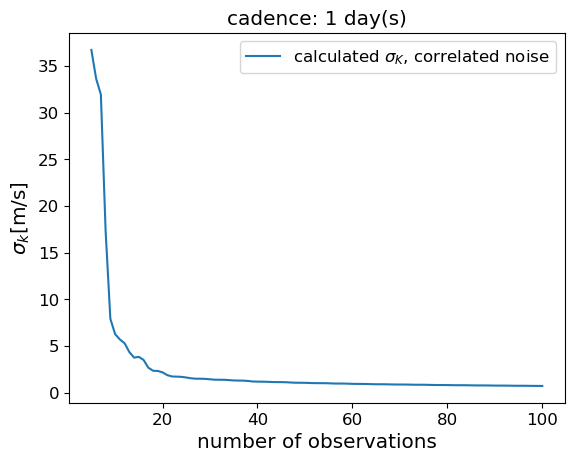

In [26]:
plt.plot(np.arange(len(sigma_ks))+5, np.array(sigma_ks_qp), label='calculated $\sigma_K$, correlated noise')
plt.xlabel('number of observations')
plt.ylabel(r"$\sigma_k$[m/s]")
plt.title(f"cadence: {cadence} day(s)")
plt.legend()
#plt.ylim([0,200])
plt.show()

#### A Brief Aside to Combine Plots for the Paper

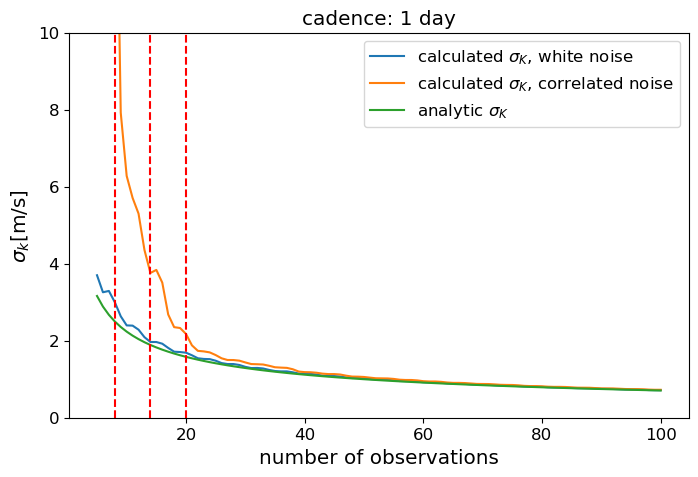

In [59]:
plt.plot(np.arange(len(sigma_ks))+4, np.array(sigma_ks), label='calculated $\sigma_K$, white noise')
plt.plot(np.arange(len(sigma_ks_qp))+4, np.array(sigma_ks_qp), label='calculated $\sigma_K$, correlated noise')
plt.plot(np.arange(len(sigma_ks))+4, sigma_wn_rv * np.sqrt(2/(np.arange(len(sigma_ks))+4)), label='analytic $\sigma_K$')
plt.xlabel('number of observations')
plt.ylabel(r"$\sigma_k$[m/s]")
plt.title(f"cadence: {cadence} day")
plt.legend()
plt.ylim([0, 10])

plt.vlines([8, 14, 20], 0, 10, linestyle='--', color='red')
#plt.savefig(path + f"plots/n_obs_meters.png", format="png")
plt.show()

In [46]:
Prot, p, cadence, star.sigma_qp_rv

(4.86, 8.46, 1, None)

Why are there bumps even in the white noise case? Find bumps and find out why they're there.

In [84]:
sigma_ks = []
n_obs = 4
periods = [p/2, p, 10.1, p*2]
sigma_ks1 = []
for i in tqdm(range(60)):
    
        
    # instantiate Star object in order to feed covariance matrix with white/correlated noise
    star = calculate_fi.Star(sigma_wn_rv = sigma_wn_rv)

    # populate list of parameters to feed into cov_matrix_jax()
    params = star.param_list()

    # instantiate Planets object in order to feed Fisher Info calculation machinery
    planet = calculate_fi.Planets(K = K, p = p/2, T0 = T0)

    # populate list of parameters to feed into clam_jax_fim()
    theta = planet.theta_list()

    # instantiate Strategy object in order to build time series of observations
    strategy = strategies.Strategy(n_obs = n_obs, start = start, offs=[], dropout=0.)

    # build strategy aka time series of observations
    #strat = strategy.gappy(cadence)
    strat = strategy.on_vs_off(on=1, off=0, twice_flag=False)

    #sigma = calculate_fi.cov_matrix_jax(strat, params) # non-object-oriented
    #sigma = star.cov_matrix(strat) # object-oriented but w/manual QP GP kernel
    sigma = star.cov_matrix_general(strat) # object-oriented with custom kernels
    sigma += 1e-6 

    # populate arguments for Fisher Info calculator
    args = np.array(strat), sigma, jnp.array(theta, dtype=float)

    # calculate FI
    fim = calculate_fi.clam_jax_fim(*args).block_until_ready()#[0][0]
    #sigma_k = 1/fim

    # invert FI matrix
    inv_fim = inv(fim)

    # top left element of matrix corresponds with RV semi-amplitude, K
    sigma_k = np.sqrt(inv_fim)[0][0]
    sigma_ks1.append(sigma_k)

    n_obs += 1


  0%|                                                                                                                    | 0/60 [00:00<?, ?it/s]/var/folders/fm/fpkllzw93kq7c5y3zl98167m0000gn/T/ipykernel_2954/4054728508.py:43: RuntimeWarning: invalid value encountered in sqrt
  sigma_k = np.sqrt(inv_fim)[0][0]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:00<00:00, 557.04it/s]


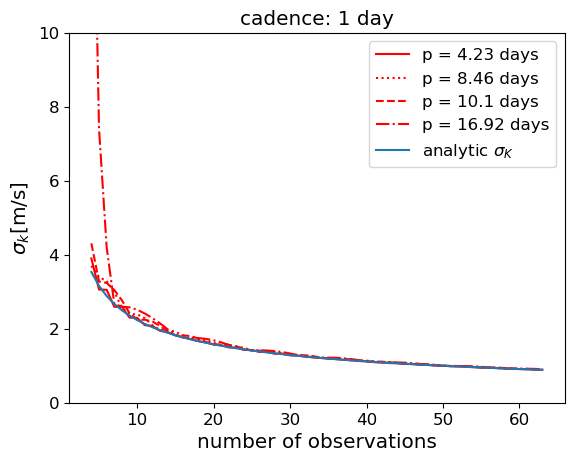

In [94]:
plt.plot(np.arange(len(sigma_ks1))+4, np.array(sigma_ks1), label='p = 4.23 days', color='red')
plt.plot(np.arange(len(sigma_ks2))+4, np.array(sigma_ks2), label='p = 8.46 days', linestyle='dotted', color='red')
plt.plot(np.arange(len(sigma_ks3))+4, np.array(sigma_ks3), label='p = 10.1 days', linestyle='--', color='red')
plt.plot(np.arange(len(sigma_ks4))+4, np.array(sigma_ks4), label='p = 16.92 days', linestyle='dashdot', color='red')

#plt.plot(np.arange(len(sigma_ks_qp))+4, np.array(sigma_ks_qp), label='calculated $\sigma_K$, correlated noise')
plt.plot(np.arange(len(sigma_ks4))+4, sigma_wn_rv * np.sqrt(2/(np.arange(len(sigma_ks4))+4)), label='analytic $\sigma_K$')
plt.xlabel('number of observations')
plt.ylabel(r"$\sigma_k$[m/s]")
plt.title(f"cadence: {cadence} day")
plt.legend()
plt.ylim([0, 10])

#plt.vlines([8, 14, 20], 0, 10, linestyle='--', color='red')
#plt.savefig(path + f"plots/n_obs_meters.png", format="png")
plt.show()

Why the bumps? Let's take the residuals and run them through a periodogram (suggestion by Lily Zhao). 

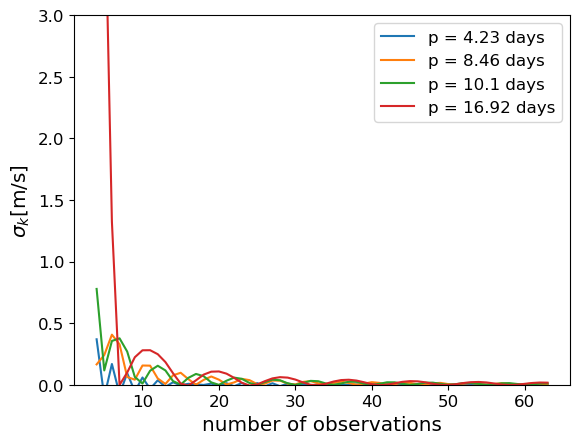

In [102]:
residual1 = np.array(sigma_ks1) - sigma_wn_rv * np.sqrt(2/(np.arange(len(sigma_ks1))+4))
residual2 = np.array(sigma_ks2) - sigma_wn_rv * np.sqrt(2/(np.arange(len(sigma_ks2))+4))
residual3 = np.array(sigma_ks3) - sigma_wn_rv * np.sqrt(2/(np.arange(len(sigma_ks3))+4))
residual4 = np.array(sigma_ks4) - sigma_wn_rv * np.sqrt(2/(np.arange(len(sigma_ks4))+4))
plt.plot(np.arange(len(sigma_ks1))+4, residual1, label='p = 4.23 days')
plt.plot(np.arange(len(sigma_ks2))+4, residual2, label='p = 8.46 days')
plt.plot(np.arange(len(sigma_ks3))+4, residual3, label='p = 10.1 days')
plt.plot(np.arange(len(sigma_ks4))+4, residual4, label='p = 16.92 days')
plt.ylim([0, 3])
plt.xlabel('number of observations')
plt.ylabel(r"$\sigma_k$[m/s]")
plt.legend()
plt.show()

In [100]:
from scipy.signal import find_peaks
print(find_peaks(residual1)[0] + 4)
print(find_peaks(residual2)[0] + 4)
print(find_peaks(residual3)[0] + 4)
print(find_peaks(residual4)[0] + 4)
print("")
print(np.median(np.diff(find_peaks(residual1)[0] + 4)))
print(np.median(np.diff(find_peaks(residual2)[0] + 4)))
print(np.median(np.diff(find_peaks(residual3)[0] + 4)))
print(np.median(np.diff(find_peaks(residual4)[0] + 4)))

[ 6  8 10 12 14 16 19 21 23 25 27 29 31 33 35 38 40 42 44 46 48 50 52 55
 57 59 61]
[ 6 10 15 19 23 27 32 36 40 44 49 53 57 61]
[ 7 12 17 22 27 32 37 42 48 53 58]
[11 20 28 37 45 54 62]

2.0
4.0
5.0
8.5


why does going from 13 to 14 observations, or from 9 to 10, increase sigma_K?

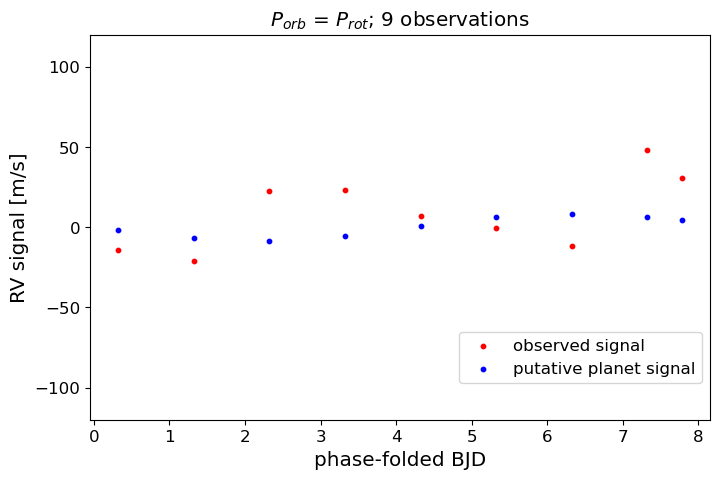

In [126]:
strategy = strategies.Strategy(n_obs = 9, start = start, offs=[], dropout=0.)

# build strategy aka time series of observations
#strat = strategy.gappy(cadence)
strat = strategy.on_vs_off(on=1, off=0, twice_flag=False)

t_phase_folded = strat % p # phase fold support
y_phase_folded = np.array(calculate_fi.model_jax(t_phase_folded, theta))

gp = GaussianProcess(kernel, strat)
sample = gp.sample(jax.random.PRNGKey(4), shape=(1,))


plt.rcParams["figure.figsize"] = (8,5)
#plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]

from scipy.stats import binned_statistic

# first, create fiducial model of the planet signal
y = calculate_fi.model_jax(strat, theta)

# bin the observed signal of planet + stellar signal, phase-folded by orbital period
bins = 10
mean_stat_observed = binned_statistic((strat-T0) % p, sample + y, 
                             statistic='mean', 
                             bins=bins, range=(0, p))

# bin the observed signal of just the planet signal, phase-folded by orbital period
bins = 10
mean_stat_planet = binned_statistic((strat-T0) % p, y, 
                             statistic='mean', 
                             bins=bins, range=(0, p))

plt.scatter((strat-T0) % p, sample + y_phase_folded, label='observed signal', c='red', s=10)
#plt.scatter(mean_stat_observed.bin_edges[:-1], mean_stat_observed.statistic, label='binned observed signal', s=60, 
#            facecolors='none', edgecolors='r')
plt.scatter((strat-T0) % p, y_phase_folded, label='putative planet signal', c='blue', s=10)
#plt.scatter(mean_stat_planet.bin_edges[:-1], mean_stat_planet.statistic, label='binned planet signal', s=60, 
#            facecolors='none', edgecolors='blue')

plt.xlabel('phase-folded BJD')
plt.ylabel('RV signal [m/s]')
plt.title(r'$P_{orb}$ = $P_{rot}$; 9 observations')
plt.ylim([-120, 120])
plt.legend(bbox_to_anchor=(1.0, 0.25))
#plt.savefig(path + 'plots/beat-freq1.pdf', format='pdf', bbox_inches='tight')
plt.show()

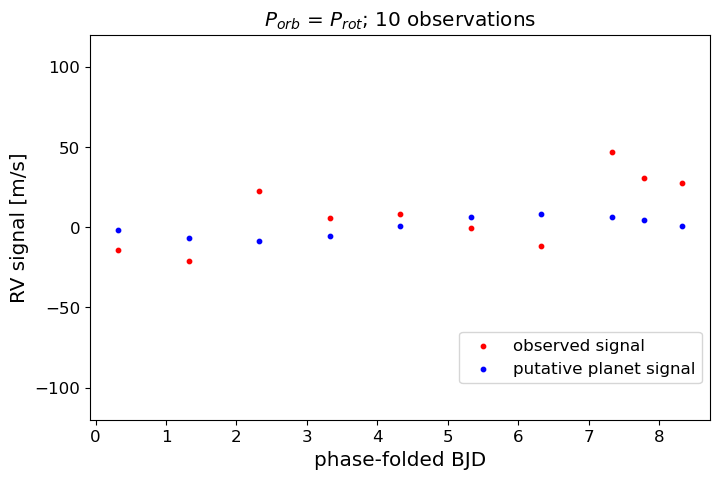

In [127]:
strategy = strategies.Strategy(n_obs = 10, start = start, offs=[], dropout=0.)

# build strategy aka time series of observations
#strat = strategy.gappy(cadence)
strat = strategy.on_vs_off(on=1, off=0, twice_flag=False)

t_phase_folded = strat % p # phase fold support
y_phase_folded = np.array(calculate_fi.model_jax(t_phase_folded, theta))

gp = GaussianProcess(kernel, strat)
sample = gp.sample(jax.random.PRNGKey(4), shape=(1,))

plt.rcParams["figure.figsize"] = (8,5)
#plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]

from scipy.stats import binned_statistic

# first, create fiducial model of the planet signal
y = calculate_fi.model_jax(strat, theta)

# bin the observed signal of planet + stellar signal, phase-folded by orbital period
bins = 10
mean_stat_observed = binned_statistic((strat-T0) % p, sample + y, 
                             statistic='mean', 
                             bins=bins, range=(0, p))

# bin the observed signal of just the planet signal, phase-folded by orbital period
bins = 10
mean_stat_planet = binned_statistic((strat-T0) % p, y, 
                             statistic='mean', 
                             bins=bins, range=(0, p))

plt.scatter((strat-T0) % p, sample + y_phase_folded, label='observed signal', c='red', s=10)
#plt.scatter(mean_stat_observed.bin_edges[:-1], mean_stat_observed.statistic, label='binned observed signal', s=60, 
#            facecolors='none', edgecolors='r')
plt.scatter((strat-T0) % p, y_phase_folded, label='putative planet signal', c='blue', s=10)
#plt.scatter(mean_stat_planet.bin_edges[:-1], mean_stat_planet.statistic, label='binned planet signal', s=60, 
#            facecolors='none', edgecolors='blue')

plt.xlabel('phase-folded BJD')
plt.ylabel('RV signal [m/s]')
plt.title(r'$P_{orb}$ = $P_{rot}$; 10 observations')
plt.ylim([-120, 120])
plt.legend(bbox_to_anchor=(1.0, 0.25))
#plt.savefig(path + 'plots/beat-freq1.pdf', format='pdf', bbox_inches='tight')
plt.show()

How about not phase-folded?

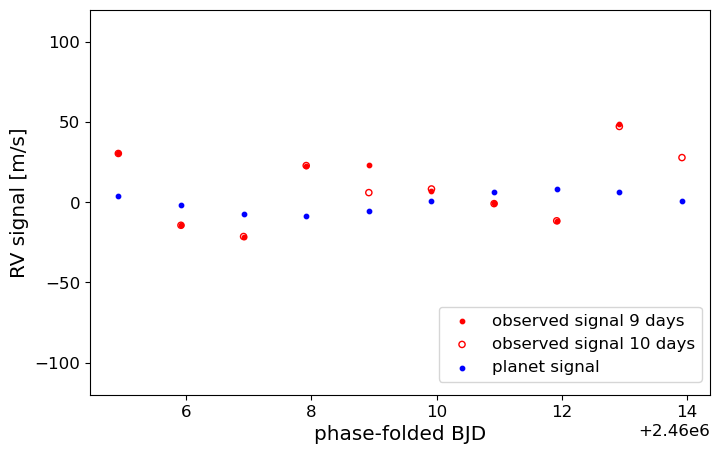

In [129]:
strategy = strategies.Strategy(n_obs = 9, start = start, offs=[], dropout=0.)
strat1 = strategy.on_vs_off(on=1, off=0, twice_flag=False)
gp = GaussianProcess(kernel, strat1)
sample1 = gp.sample(jax.random.PRNGKey(4), shape=(1,))
y1 = calculate_fi.model_jax(strat1, theta)

strategy = strategies.Strategy(n_obs = 10, start = start, offs=[], dropout=0.)
strat2 = strategy.on_vs_off(on=1, off=0, twice_flag=False)
gp = GaussianProcess(kernel, strat2)
sample2 = gp.sample(jax.random.PRNGKey(4), shape=(1,))
y2 = calculate_fi.model_jax(strat2, theta)

plt.scatter((strat1), sample1 + y1, label='observed signal 9 days', c='red', s=10)
plt.scatter((strat2), sample2 + y2, label='observed signal 10 days', s=20, facecolors='none', edgecolors='r')
plt.scatter((strat2), y2, label='planet signal', c='blue', s=10)

plt.xlabel('phase-folded BJD')
plt.ylabel('RV signal [m/s]')
plt.ylim([-120, 120])
plt.legend(bbox_to_anchor=(1.0, 0.25))
plt.show()

In [121]:
print(strat1)
print(strat2)

[2460005.03466115 2460006.03466115 2460007.03466115 2460008.03466115
 2460009.03466115 2460010.03466115 2460011.03466115 2460012.03466115
 2460013.03466115]
[2460004.90643052 2460005.90643052 2460006.90643052 2460007.90643052
 2460008.90643052 2460009.90643052 2460010.90643052 2460011.90643052
 2460012.90643052 2460013.90643052]


In [123]:
strategy = strategies.Strategy(n_obs = 9, start = start, offs=[], dropout=0.)
strat = np.array(strategy.on_vs_off(on=1, off=0, twice_flag=False))
print(strat)

strategy = strategies.Strategy(n_obs = 10, start = start, offs=[], dropout=0.)
strat = np.array(strategy.on_vs_off(on=1, off=0, twice_flag=False))
print(strat)

[2460004.91666667 2460005.91666667 2460006.91666667 2460007.91666667
 2460008.91666667 2460009.91666667 2460010.91666667 2460011.91666667
 2460012.91666667]
[2460004.91666667 2460005.91666667 2460006.91666667 2460007.91666667
 2460008.91666667 2460009.91666667 2460010.91666667 2460011.91666667
 2460012.91666667 2460013.91666667]
